<h1 style="text-align:center;font-size:30px;" > Question Pairs Similarity Finding
 </h1>






<h1> 1. Main Problem Objective
 </h1>

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.1 Source Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 

<h2>Mapping the real world problem to an ML problem </h2>

<h3> Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> Performance Metric </h3>



Metric(s): 
* log-loss :
* Binary Confusion Matrix

<h2>Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [ ]:
pip install distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 180 kB 4.2 MB/s 
  Created wheel for distance: filename=Distance-0.1.3-py3-none-any.whl size=16289 sha256=98d57b556e0d49dc1a9f499adb8d19792210735f049d005fdfb2887812710c1a
  Stored in directory: /root/.cache/pip/wheels/b2/10/1b/96fca621a1be378e2fe104cfb0d160bb6cdf3d04a3d35266cc
Successfully built distance


In [ ]:
pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<h2> Reading data and basic stats </h2>

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Ml package/train.csv",engine="python",error_bad_lines=False)

print("Number of data points:",df.shape[0])

Number of data points: 10000


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            10000 non-null  int64 
 1   qid1          10000 non-null  int64 
 2   qid2          10000 non-null  int64 
 3   question1     10000 non-null  object
 4   question2     10000 non-null  object
 5   is_duplicate  10000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 468.9+ KB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3>Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

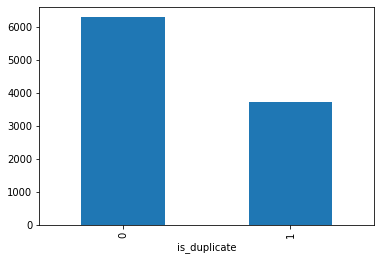

In [ ]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   10000


In [ ]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   62.89%

~> Question pairs are Similar (is_duplicate = 1):
   37.11%


<h3> Number of unique questions </h3>

In [ ]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 19413

Number of unique questions that appear more than one time: 536 (2.7610364188945553%)

Max number of times a single question is repeated: 4



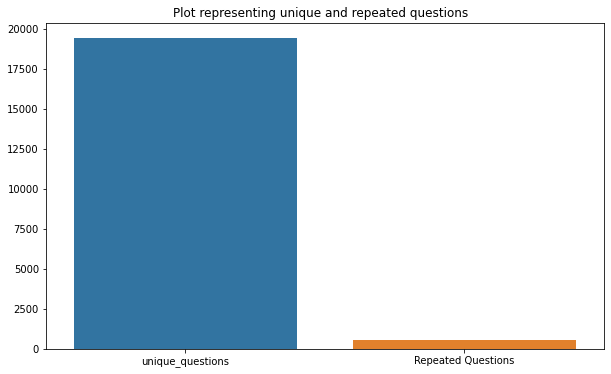

In [ ]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>Checking for Duplicates </h3>

In [ ]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> Number of occurrences of each question </h3>

In [ ]:
import matplotlib

Maximum number of times a single question is repeated: 4



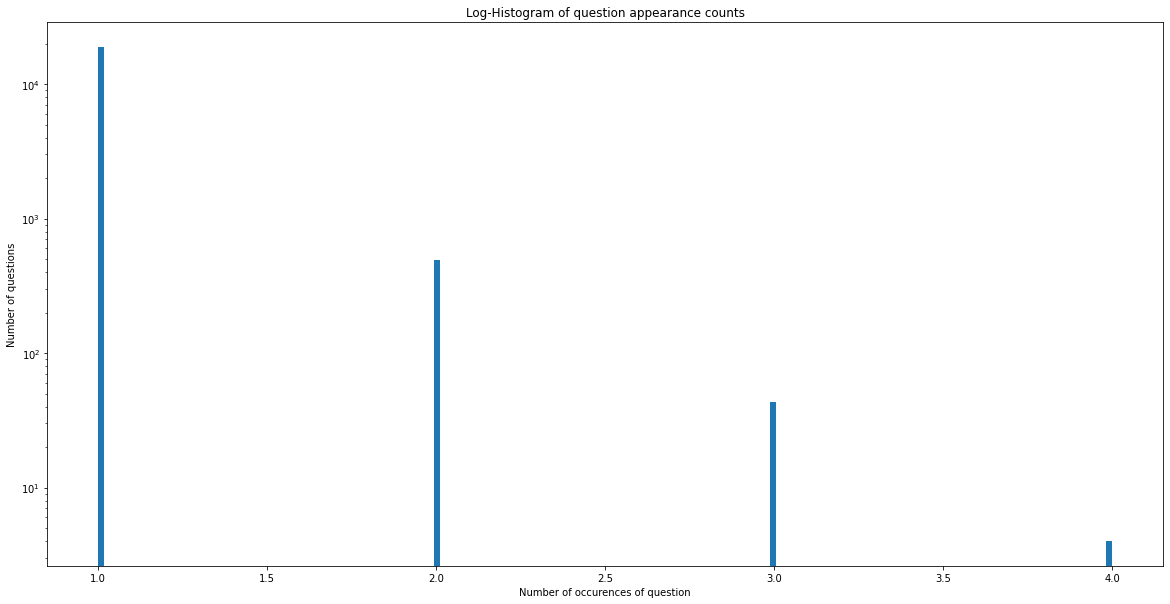

In [ ]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3>Checking for NULL values </h3>

In [ ]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


- There are two rows with null values in question2 

In [ ]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2> Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [ ]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [ ]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  3
Number of Questions with minimum length [question1] : 1
Number of Questions with minimum length [question2] : 0


<h4> 3.3.1.1 Feature: word_share </h4>

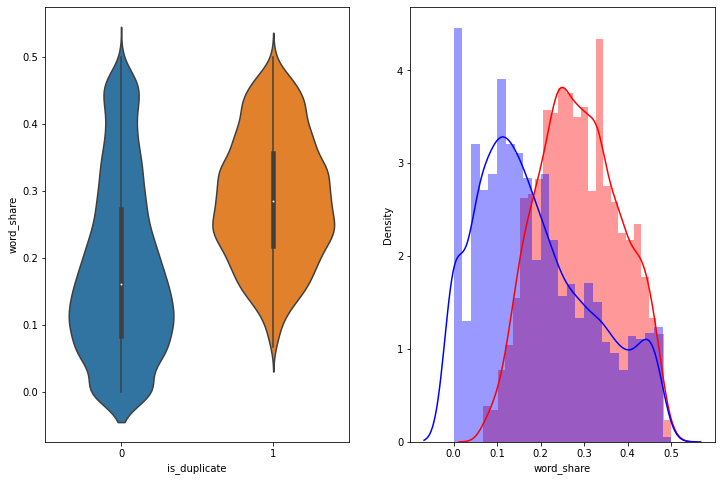

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

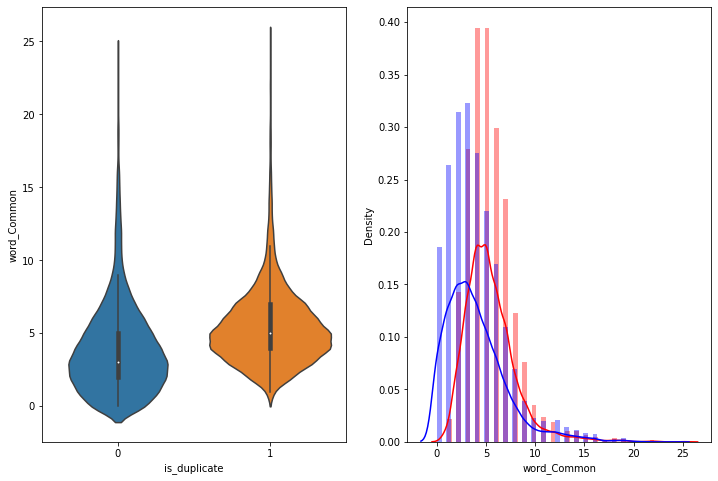

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

In [ ]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [ ]:
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


<h2> Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [ ]:
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>

- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [ ]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/content/drive/MyDrive/Ml package/mm.csv",error_bad_lines=False, engine="python")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154


<h3>3.5.1 Analysis of extracted features </h3>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [ ]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 7422
Number of data points in class 0 (non duplicate pairs) : 12578


In [ ]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 397132
Total number of words in non duplicate pair questions : 820606


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


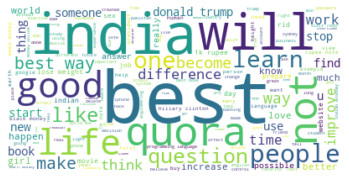

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


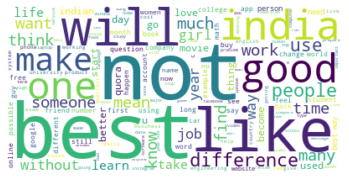

In [ ]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

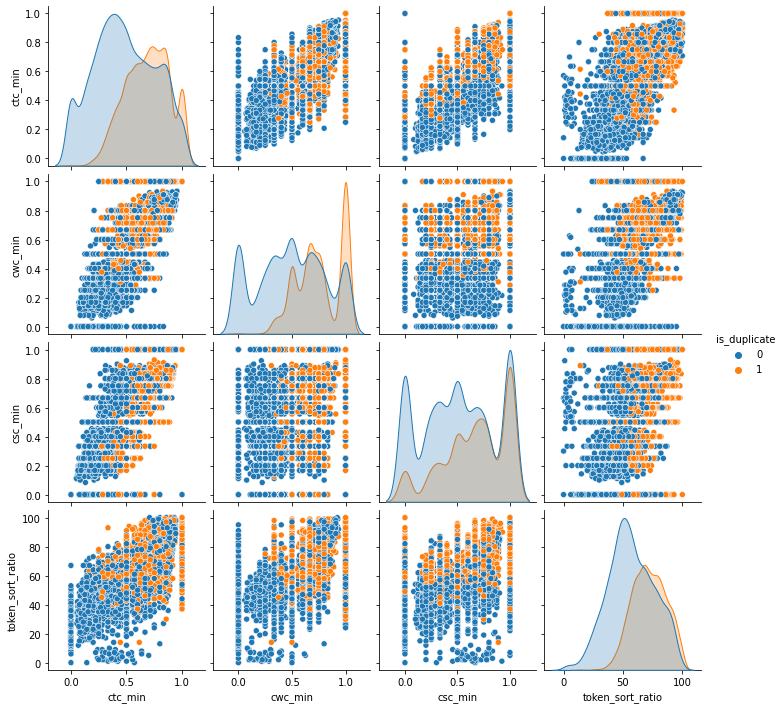

In [ ]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

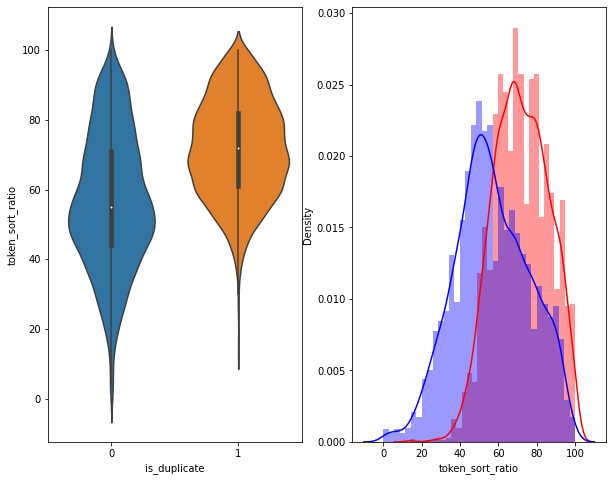

In [ ]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

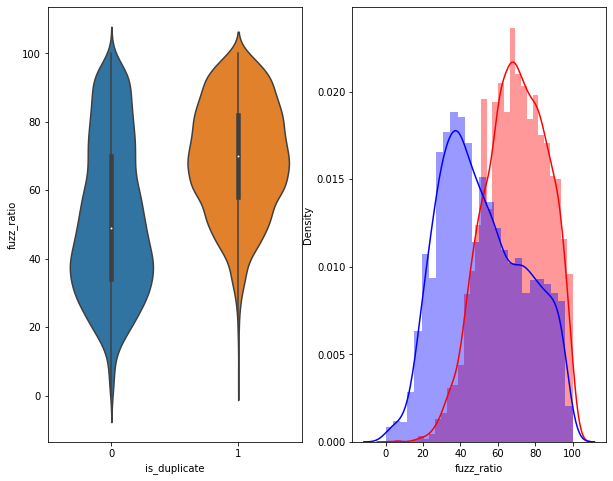

In [ ]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [ ]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [ ]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=250,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.358s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.266s
[t-SNE] Iteration 50: error = 81.3240433, gradient norm = 0.0460679 (50 iterations in 2.493s)
[t-SNE] Iteration 100: error = 70.6469879, gradient norm = 0.0087808 (50 iterations in 1.773s)
[t-SNE] Iteration 150: error = 68.9435196, gradient norm = 0.0062571 (50 iterations in 1.677s)
[t-SNE] Iteration 200: error = 68.1250000, gradient norm = 0.0042800 (50 iterations in 1.782s)
[t-SNE] Iteration 250: error = 67.6175537, gradient norm = 0.0032984

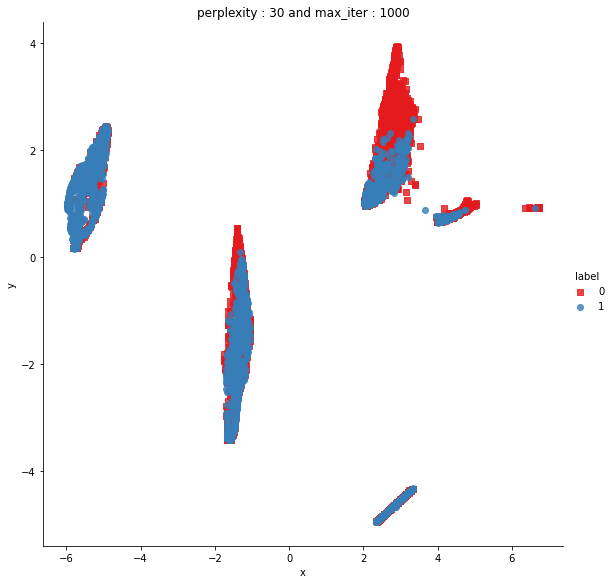

In [ ]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [ ]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=250,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...
[t-SNE] Computed neighbors for 5000 samples in 0.350s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.130446
[t-SNE] Computed conditional probabilities in 0.258s
[t-SNE] Iteration 50: error = 80.5575867, gradient norm = 0.0302160 (50 iterations in 10.431s)
[t-SNE] Iteration 100: error = 69.4190598, gradient norm = 0.0035451 (50 iterations in 4.864s)
[t-SNE] Iteration 150: error = 68.0035172, gradient norm = 0.0017021 (50 iterations in 6.554s)
[t-SNE] Iteration 200: error = 67.4366684, gradient norm = 0.0011509 (50 iterations in 4.588s)
[t-SNE] Iteration 250: error = 67.1219788, gradient norm = 0.000924

bold text<h2>Featurizing text data with tfidf weighted word-vectors </h2>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy

In [ ]:

df = pd.read_csv("/content/drive/MyDrive/Ml package/train.csv",error_bad_lines=False, engine="python")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase=False,)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
import en_core_web_sm
import numpy as np

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = en_core_web_sm.load()

vecs1 = []
# tqdm is used to print the progress bar
for qu1 in tqdm(list(df['question1'])):
    doc1 = nlp(qu1) 
    # 96 number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 96])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1*idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
df['q1_feats_m'] = list(vecs1)


100%|██████████| 10000/10000 [01:47<00:00, 93.38it/s]


In [ ]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 96])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|██████████| 10000/10000 [01:42<00:00, 97.50it/s]


In [ ]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    dfnlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("download nlp_features_train.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    dfppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train.csv from drive or run previous notebook")

In [ ]:
df1 = dfnlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = dfppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index= df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index= df3.index)

In [ ]:
# dataframe of nlp features
df1.head()

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.039216
4,4,0,0.399992,0.199998,0.999950,0.666644,0.571420,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000


In [ ]:
# data before preprocessing 
df2.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [ ]:
# Questions 1 tfidf weighted word2vec
df3_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,28.196306,-6.130472,28.292818,-35.248495,-13.635966,2.908309,-33.951159,-40.008043,13.804615,7.730064,...,20.837701,-1.536684,-25.633683,14.266973,-43.895010,-52.154748,39.771683,65.032045,3.680211,1.706937
1,69.856780,11.606112,7.226902,-12.003976,-28.387100,35.363531,-41.771429,-4.096308,19.909978,-7.407165,...,9.169445,-7.557923,-55.798217,6.129164,5.973435,-40.766526,-17.150524,40.453788,22.694690,22.196361
2,16.675528,10.546858,-16.248936,-1.661422,-12.464421,-3.564246,-5.176420,-41.042537,19.145558,0.508374,...,36.803776,14.608305,6.240449,36.533479,-31.050745,-34.141792,-1.085950,-18.434720,6.698737,-8.614364
3,25.054356,60.012866,-18.753264,-17.393754,10.309683,33.990143,-7.385397,-18.771516,36.563361,-18.311675,...,-17.807404,17.927960,-10.837254,5.840440,1.340690,9.837409,32.453045,-20.222952,37.031908,-12.747323
4,84.264972,-30.522664,29.408908,-28.714688,30.598443,13.616794,-17.410143,-64.743854,80.641635,-5.736674,...,-40.177648,0.946670,-24.472378,34.062175,29.452512,-39.438359,12.854536,25.508907,31.446531,44.169589


In [ ]:
# Questions 2 tfidf weighted word2vec
df3_q2.head()

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,23.861876,-3.810469,16.867613,-28.686537,-8.506184,2.219004,-16.509189,-35.365637,5.043903,1.186660,...,27.475909,1.553612,-11.769997,11.088176,-46.564834,-48.225411,44.009401,34.884243,9.104843,-10.483541
1,62.374515,18.843253,0.931677,7.104583,6.819137,56.413660,-44.245397,-1.241754,27.731613,-10.405267,...,9.901248,-2.265529,-33.710894,11.241922,-4.163853,-37.483706,-6.004893,24.912247,43.332301,3.560024
2,-3.992276,23.787005,31.455311,-16.343594,-26.112671,17.783155,-30.126150,-18.279056,23.587215,36.186947,...,16.663018,-15.387252,10.950042,35.578733,-56.479053,-57.276338,23.911333,-8.734079,17.641656,3.366309
3,7.713014,52.766958,-4.049111,0.955656,-36.634743,9.533249,11.977845,-6.946094,18.921719,11.931501,...,0.961777,3.732045,13.917824,16.005986,-37.745149,-26.277188,-11.267948,-12.835954,7.520793,-37.795490
4,32.067699,-15.185345,-2.661156,-5.054361,6.061200,20.970284,-6.047251,-16.886029,15.762281,1.470695,...,8.709073,7.125288,-25.329150,17.570244,-7.910676,-22.606321,23.396829,-9.571365,23.684867,-0.091329


In [ ]:
print("Number of features in nlp dataframe :", df1.shape[1])
print("Number of features in preprocessed dataframe :", df2.shape[1])
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df1.shape[1]+df2.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in nlp dataframe : 17
Number of features in preprocessed dataframe : 12
Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 221


In [ ]:
# storing the final features to csv file
if not os.path.isfile('final_features.csv'):
    df3_q1['id']=df1['id']
    df3_q2['id']=df1['id']
    df1  = df1.merge(df2, on='id',how='left')
    df2  = df3_q1.merge(df3_q2, on='id',how='left')
    result  = df1.merge(df2, on='id',how='left')
    result.to_csv('final_features.csv')

Libraries For Machine Learning Model
 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
#from mlxtend.ensemble import StackingCVClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Reading data from file and storing into sql table </h2>

In [ ]:
#Creating db file from csv
if not os.path.isfile('train.db'):
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('final_features.csv', names=['Unnamed: 0','id','is_duplicate','cwc_min','cwc_max','csc_min','csc_max','ctc_min','ctc_max','last_word_eq','first_word_eq','abs_len_diff','mean_len','token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio','freq_qid1','freq_qid2','q1len','q2len','q1_n_words','q2_n_words','word_Common','word_Total','word_share','freq_q1+q2','freq_q1-q2','0_x','1_x','2_x','3_x','4_x','5_x','6_x','7_x','8_x','9_x','10_x','11_x','12_x','13_x','14_x','15_x','16_x','17_x','18_x','19_x','20_x','21_x','22_x','23_x','24_x','25_x','26_x','27_x','28_x','29_x','30_x','31_x','32_x','33_x','34_x','35_x','36_x','37_x','38_x','39_x','40_x','41_x','42_x','43_x','44_x','45_x','46_x','47_x','48_x','49_x','50_x','51_x','52_x','53_x','54_x','55_x','56_x','57_x','58_x','59_x','60_x','61_x','62_x','63_x','64_x','65_x','66_x','67_x','68_x','69_x','70_x','71_x','72_x','73_x','74_x','75_x','76_x','77_x','78_x','79_x','80_x','81_x','82_x','83_x','84_x','85_x','86_x','87_x','88_x','89_x','90_x','91_x','92_x','93_x','94_x','95_x','96_x','97_x','98_x','99_x','100_x','101_x','102_x','103_x','104_x','105_x','106_x','107_x','108_x','109_x','110_x','111_x','112_x','113_x','114_x','115_x','116_x','117_x','118_x','119_x','120_x','121_x','122_x','123_x','124_x','125_x','126_x','127_x','128_x','129_x','130_x','131_x','132_x','133_x','134_x','135_x','136_x','137_x','138_x','139_x','140_x','141_x','142_x','143_x','144_x','145_x','146_x','147_x','148_x','149_x','150_x','151_x','152_x','153_x','154_x','155_x','156_x','157_x','158_x','159_x','160_x','161_x','162_x','163_x','164_x','165_x','166_x','167_x','168_x','169_x','170_x','171_x','172_x','173_x','174_x','175_x','176_x','177_x','178_x','179_x','180_x','181_x','182_x','183_x','184_x','185_x','186_x','187_x','188_x','189_x','190_x','191_x','192_x','193_x','194_x','195_x','196_x','197_x','198_x','199_x','200_x','201_x','202_x','203_x','204_x','205_x','206_x','207_x','208_x','209_x','210_x','211_x','212_x','213_x','214_x','215_x','216_x','217_x','218_x','219_x','220_x','221_x','222_x','223_x','224_x','225_x','226_x','227_x','228_x','229_x','230_x','231_x','232_x','233_x','234_x','235_x','236_x','237_x','238_x','239_x','240_x','241_x','242_x','243_x','244_x','245_x','246_x','247_x','248_x','249_x','250_x','251_x','252_x','253_x','254_x','255_x','256_x','257_x','258_x','259_x','260_x','261_x','262_x','263_x','264_x','265_x','266_x','267_x','268_x','269_x','270_x','271_x','272_x','273_x','274_x','275_x','276_x','277_x','278_x','279_x','280_x','281_x','282_x','283_x','284_x','285_x','286_x','287_x','288_x','289_x','290_x','291_x','292_x','293_x','294_x','295_x','296_x','297_x','298_x','299_x','300_x','301_x','302_x','303_x','304_x','305_x','306_x','307_x','308_x','309_x','310_x','311_x','312_x','313_x','314_x','315_x','316_x','317_x','318_x','319_x','320_x','321_x','322_x','323_x','324_x','325_x','326_x','327_x','328_x','329_x','330_x','331_x','332_x','333_x','334_x','335_x','336_x','337_x','338_x','339_x','340_x','341_x','342_x','343_x','344_x','345_x','346_x','347_x','348_x','349_x','350_x','351_x','352_x','353_x','354_x','355_x','356_x','357_x','358_x','359_x','360_x','361_x','362_x','363_x','364_x','365_x','366_x','367_x','368_x','369_x','370_x','371_x','372_x','373_x','374_x','375_x','376_x','377_x','378_x','379_x','380_x','381_x','382_x','383_x','0_y','1_y','2_y','3_y','4_y','5_y','6_y','7_y','8_y','9_y','10_y','11_y','12_y','13_y','14_y','15_y','16_y','17_y','18_y','19_y','20_y','21_y','22_y','23_y','24_y','25_y','26_y','27_y','28_y','29_y','30_y','31_y','32_y','33_y','34_y','35_y','36_y','37_y','38_y','39_y','40_y','41_y','42_y','43_y','44_y','45_y','46_y','47_y','48_y','49_y','50_y','51_y','52_y','53_y','54_y','55_y','56_y','57_y','58_y','59_y','60_y','61_y','62_y','63_y','64_y','65_y','66_y','67_y','68_y','69_y','70_y','71_y','72_y','73_y','74_y','75_y','76_y','77_y','78_y','79_y','80_y','81_y','82_y','83_y','84_y','85_y','86_y','87_y','88_y','89_y','90_y','91_y','92_y','93_y','94_y','95_y','96_y','97_y','98_y','99_y','100_y','101_y','102_y','103_y','104_y','105_y','106_y','107_y','108_y','109_y','110_y','111_y','112_y','113_y','114_y','115_y','116_y','117_y','118_y','119_y','120_y','121_y','122_y','123_y','124_y','125_y','126_y','127_y','128_y','129_y','130_y','131_y','132_y','133_y','134_y','135_y','136_y','137_y','138_y','139_y','140_y','141_y','142_y','143_y','144_y','145_y','146_y','147_y','148_y','149_y','150_y','151_y','152_y','153_y','154_y','155_y','156_y','157_y','158_y','159_y','160_y','161_y','162_y','163_y','164_y','165_y','166_y','167_y','168_y','169_y','170_y','171_y','172_y','173_y','174_y','175_y','176_y','177_y','178_y','179_y','180_y','181_y','182_y','183_y','184_y','185_y','186_y','187_y','188_y','189_y','190_y','191_y','192_y','193_y','194_y','195_y','196_y','197_y','198_y','199_y','200_y','201_y','202_y','203_y','204_y','205_y','206_y','207_y','208_y','209_y','210_y','211_y','212_y','213_y','214_y','215_y','216_y','217_y','218_y','219_y','220_y','221_y','222_y','223_y','224_y','225_y','226_y','227_y','228_y','229_y','230_y','231_y','232_y','233_y','234_y','235_y','236_y','237_y','238_y','239_y','240_y','241_y','242_y','243_y','244_y','245_y','246_y','247_y','248_y','249_y','250_y','251_y','252_y','253_y','254_y','255_y','256_y','257_y','258_y','259_y','260_y','261_y','262_y','263_y','264_y','265_y','266_y','267_y','268_y','269_y','270_y','271_y','272_y','273_y','274_y','275_y','276_y','277_y','278_y','279_y','280_y','281_y','282_y','283_y','284_y','285_y','286_y','287_y','288_y','289_y','290_y','291_y','292_y','293_y','294_y','295_y','296_y','297_y','298_y','299_y','300_y','301_y','302_y','303_y','304_y','305_y','306_y','307_y','308_y','309_y','310_y','311_y','312_y','313_y','314_y','315_y','316_y','317_y','318_y','319_y','320_y','321_y','322_y','323_y','324_y','325_y','326_y','327_y','328_y','329_y','330_y','331_y','332_y','333_y','334_y','335_y','336_y','337_y','338_y','339_y','340_y','341_y','342_y','343_y','344_y','345_y','346_y','347_y','348_y','349_y','350_y','351_y','352_y','353_y','354_y','355_y','356_y','357_y','358_y','359_y','360_y','361_y','362_y','363_y','364_y','365_y','366_y','367_y','368_y','369_y','370_y','371_y','372_y','373_y','374_y','375_y','376_y','377_y','378_y','379_y','380_y','381_y','382_y','383_y'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1

In [ ]:
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None


def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the db:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

In [ ]:
read_db = 'train.db'
conn_r = create_connection(read_db)
checkTableExists(conn_r)
conn_r.close()

Tables in the db:
data


In [ ]:
# try to sample data according to the computing power you have
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        # for selecting first 1M rows
        # data = pd.read_sql_query("""SELECT * FROM data LIMIT 100001;""", conn_r)
        
        # for selecting random points
        data = pd.read_sql_query("SELECT * From data ;", conn_r)
        conn_r.commit()
        conn_r.close()

In [ ]:
# remove the first row 
data.drop(data.index[0], inplace=True)
y_true = data['is_duplicate']
data.drop(['Unnamed: 0', 'id','index','is_duplicate'], axis=1, inplace=True)

In [ ]:
data.head()

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,0.999980000399992,0.8333194446759221,0.9999833336111064,0.9999833336111064,0.9166590278414348,0.7857086735094749,0.0,1.0,2.0,13.0,...,None,None,None,None,None,None,None,None,None,None
2,0.7999840003199936,0.3999960000399996,0.7499812504687383,0.5999880002399952,0.6999930000699993,0.4666635555762962,0.0,1.0,5.0,12.5,...,None,None,None,None,None,None,None,None,None,None
3,0.3999920001599968,0.3333277778703688,0.3999920001599968,0.249996875039062,0.3999960000399996,0.2857122449125363,0.0,1.0,4.0,12.0,...,None,None,None,None,None,None,None,None,None,None
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,...,None,None,None,None,None,None,None,None,None,None
5,0.3999920001599968,0.1999980000199998,0.9999500024998748,0.6666444451851604,0.5714204082798817,0.3076899408466089,0.0,1.0,6.0,10.0,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Columns: 794 entries, cwc_min to 383_y
dtypes: object(794)
memory usage: 60.7+ MB


In [ ]:
cols = list(data.columns)
data = pd.DataFrame(np.array(data.values,dtype=np.float64),columns=cols)

In [ ]:
y_true = list(map(int, y_true.values))

<h2> 4.3 Random train test split( 70:30) </h2>

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(data, y_true, stratify=y_true, test_size=0.3,random_state=13)

In [ ]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 794)
Number of data points in test data : (3000, 794)


In [ ]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6288571428571429 Class 1:  0.37114285714285716
---------- Distribution of output variable in train data ----------
Class 0:  0.371 Class 1:  0.371


In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.8 MB/s 


Log loss on Test Data using Random Model 0.8889380240264091


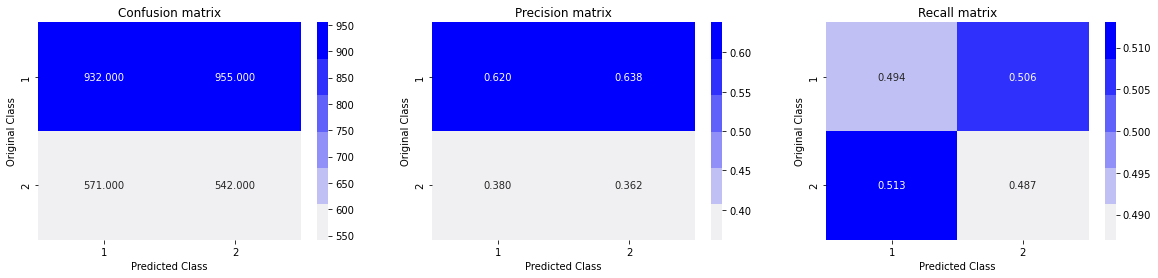

In [ ]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.4 Logistic Regression </h2>

In [ ]:
df.describe()

,Unnamed: 0,192_x,193_x,194_x,195_x,196_x,197_x,198_x,199_x,200_x,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
count,10000.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,4999.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2886.89568,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2499.75000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4999.50000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7499.25000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,9999.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [ ]:
imp.fit(X_train)

SimpleImputer()

In [ ]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [ ]:
df.describe()

In [ ]:
df

,Unnamed: 0,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
1,,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,...,,,,,,,,,,
2,0.0,0,0,0.999980000399992,0.8333194446759221,0.9999833336111064,0.9999833336111064,0.9166590278414348,0.7857086735094749,0.0,...,,,,,,,,,,
3,1.0,1,0,0.7999840003199936,0.3999960000399996,0.7499812504687383,0.5999880002399952,0.6999930000699993,0.4666635555762962,0.0,...,,,,,,,,,,
4,2.0,2,0,0.3999920001599968,0.3333277778703688,0.3999920001599968,0.249996875039062,0.3999960000399996,0.2857122449125363,0.0,...,,,,,,,,,,
5,3.0,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9995.0,9995,0,0.499995,0.277776,0.199996,0.142855,0.315788,0.249999,0.0,...,,,,,,,,,,
9998,9996.0,9996,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,,,,,,,,,,
9999,9997.0,9997,0,0.499996,0.374998,0.499975,0.199996,0.499996,0.249999,0.0,...,,,,,,,,,,
10000,9998.0,9998,1,0.999975,0.799984,0.99995,0.666644,0.999983,0.749991,1.0,...,,,,,,,,,,


In [ ]:
data.iloc[1: , :]

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,374_y,375_y,376_y,377_y,378_y,379_y,380_y,381_y,382_y,383_y
3,0.3999920001599968,0.3333277778703688,0.3999920001599968,0.249996875039062,0.3999960000399996,0.2857122449125363,0.0,1.0,4.0,12.0,...,None,None,None,None,None,None,None,None,None,None
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,...,None,None,None,None,None,None,None,None,None,None
5,0.3999920001599968,0.1999980000199998,0.9999500024998748,0.6666444451851604,0.5714204082798817,0.3076899408466089,0.0,1.0,6.0,10.0,...,None,None,None,None,None,None,None,None,None,None
6,0.6666555557407376,0.5714204082798817,0.8888790124554172,0.7999920000799993,0.7058782007164663,0.7058782007164663,1.0,0.0,0.0,17.0,...,None,None,None,None,None,None,None,None,None,None
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.5,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.49999500005,0.277776234576475,0.199996000079998,0.14285510206997,0.315787811643097,0.249998958337674,0.0,0.0,5.0,21.5,...,None,None,None,None,None,None,None,None,None,None
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,12.0,...,None,None,None,None,None,None,None,None,None,None
9998,0.499995833368055,0.374997656264648,0.499975001249937,0.199996000079998,0.499996428596939,0.249999107146046,0.0,0.0,14.0,21.0,...,None,None,None,None,None,None,None,None,None,None
9999,0.999975000624984,0.799984000319994,0.999950002499875,0.66664444518516,0.999983333611106,0.749990625117186,1.0,0.0,2.0,7.0,...,None,None,None,None,None,None,None,None,None,None


In [ ]:
data = data.fillna('')
nan_rows = data[data.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [cwc_min, cwc_max, csc_min, csc_max, ctc_min, ctc_max, last_word_eq, first_word_eq, abs_len_diff, mean_len, token_set_ratio, token_sort_ratio, fuzz_ratio, fuzz_partial_ratio, longest_substr_ratio, freq_qid1, freq_qid2, q1len, q2len, q1_n_words, q2_n_words, word_Common, word_Total, word_share, freq_q1+q2, freq_q1-q2, 0_x, 1_x, 2_x, 3_x, 4_x, 5_x, 6_x, 7_x, 8_x, 9_x, 10_x, 11_x, 12_x, 13_x, 14_x, 15_x, 16_x, 17_x, 18_x, 19_x, 20_x, 21_x, 22_x, 23_x, 24_x, 25_x, 26_x, 27_x, 28_x, 29_x, 30_x, 31_x, 32_x, 33_x, 34_x, 35_x, 36_x, 37_x, 38_x, 39_x, 40_x, 41_x, 42_x, 43_x, 44_x, 45_x, 46_x, 47_x, 48_x, 49_x, 50_x, 51_x, 52_x, 53_x, 54_x, 55_x, 56_x, 57_x, 58_x, 59_x, 60_x, 61_x, 62_x, 63_x, 64_x, 65_x, 66_x, 67_x, 68_x, 69_x, 70_x, 71_x, 72_x, 73_x, ...]
Index: []

[0 rows x 794 columns]


In [ ]:
X_train = X_train.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

In [ ]:
X_test = X_test.replace((np.inf, -np.inf, np.nan), 0).reset_index(drop=True)

For values of alpha =  1e-05 The log loss is: 0.6310123723701603
For values of alpha =  0.0001 The log loss is: 0.5614333157924974
For values of alpha =  0.001 The log loss is: 0.5507353538158399
For values of alpha =  0.01 The log loss is: 0.5574972895923318
For values of alpha =  0.1 The log loss is: 0.5441082283942782
For values of alpha =  1 The log loss is: 0.5579747538004011
For values of alpha =  10 The log loss is: 0.5725157652522214


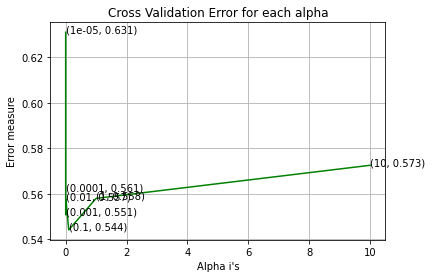

For values of best alpha =  0.1 The train log loss is: 0.5285471416368452
For values of best alpha =  0.1 The test log loss is: 0.5441082283942782
Total number of data points : 3000


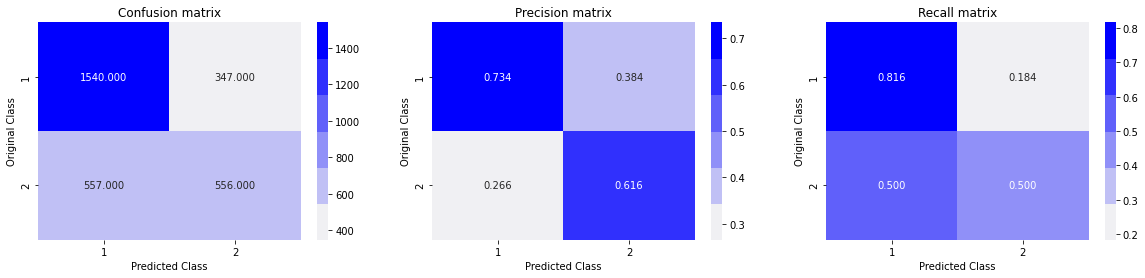

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.



log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

SGD is sensitive to feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
X_train_sc = scale.fit_transform(X_train)
X_test_sc = scale.transform(X_test)

For values of alpha =  1e-05 The log loss is: 0.5326608745923631
For values of alpha =  0.0001 The log loss is: 0.5018912216614615
For values of alpha =  0.001 The log loss is: 0.4857883354650918
For values of alpha =  0.01 The log loss is: 0.4845871172552247
For values of alpha =  0.1 The log loss is: 0.4992579476099305
For values of alpha =  1 The log loss is: 0.530021728576356
For values of alpha =  10 The log loss is: 0.555853223132311


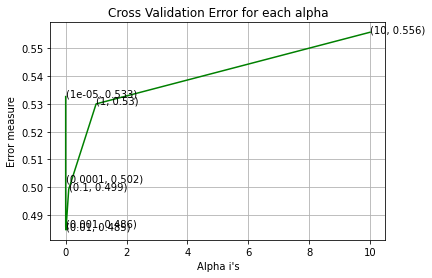

For values of best alpha =  0.01 The train log loss is: 0.4761254025307168
For values of best alpha =  0.01 The test log loss is: 0.4845871172552247
Total number of data points : 3000


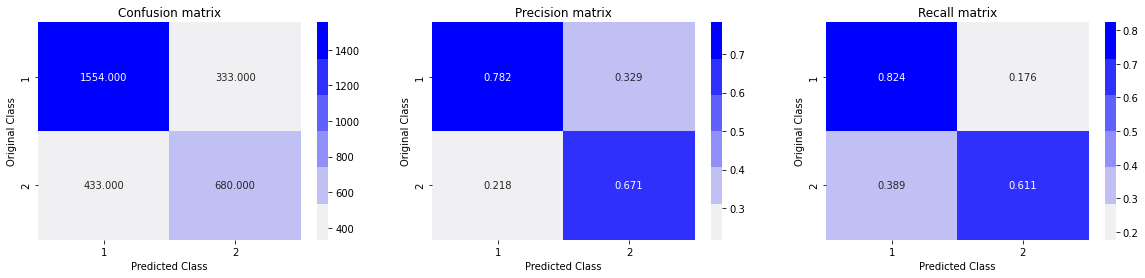

In [ ]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  0.000862 The log loss is: 0.4866271093948794
For values of alpha =  0.001017 The log loss is: 0.4857057048124309
For values of alpha =  0.001226 The log loss is: 0.48496115561678743
For values of alpha =  0.001482 The log loss is: 0.48492631893743904
For values of alpha =  0.00212 The log loss is: 0.4843817364985217
For values of alpha =  0.003 The log loss is: 0.4834013877779255
For values of alpha =  0.00314 The log loss is: 0.48333949274134375
For values of alpha =  0.003153 The log loss is: 0.4833354182436812
For values of alpha =  0.003568 The log loss is: 0.4833496224483542
For values of alpha =  0.003988 The log loss is: 0.483247095304559
For values of alpha =  0.004111 The log loss is: 0.4832257535760318
For values of alpha =  0.005223 The log loss is: 0.4835687454405797
For values of alpha =  0.005941 The log loss is: 0.4834719783464058
For values of alpha =  0.00595 The log loss is: 0.48347530751749507


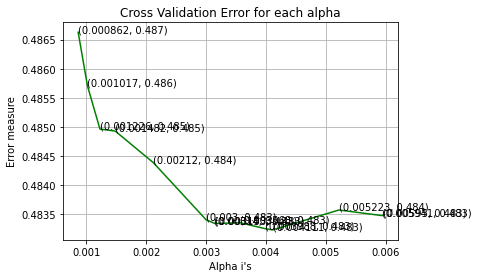

For values of best alpha =  0.004111 The train log loss is: 0.47611486022589017
For values of best alpha =  0.004111 The test log loss is: 0.4832257535760318
Total number of data points : 3000


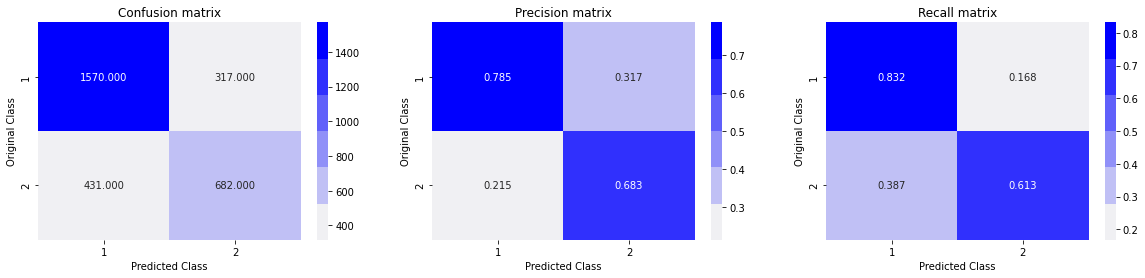

In [ ]:
#alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------
np.random.seed(45)
alpha = np.random.uniform(0.0006,0.006,14)
alpha = np.round(alpha,6)
alpha.sort()
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train_sc, y_train)
    predict_y = sig_clf.predict_proba(X_test_sc)
    log_error_array.append(log_loss(y_test, predict_y, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train_sc, y_train)

predict_y = sig_clf.predict_proba(X_train_sc)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y,eps=1e-15))
predict_y = sig_clf.predict_proba(X_test_sc)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y,eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 4.6 Random Forest </h2>

In [ ]:
from sklearn.ensemble import RandomForestClassifier as RFC

estimators =  100 Train Log Loss  0.14346478791775946 Test Log Loss  0.4896628711318979
estimators =  150 Train Log Loss  0.14397544794565298 Test Log Loss  0.48853539411957997
estimators =  200 Train Log Loss  0.14342761836717957 Test Log Loss  0.48755191852408186
estimators =  300 Train Log Loss  0.14309725445269245 Test Log Loss  0.4865072503973843
estimators =  400 Train Log Loss  0.14287836001614015 Test Log Loss  0.4853335467548731
estimators =  600 Train Log Loss  0.1428429227945608 Test Log Loss  0.48676083421588495
estimators =  800 Train Log Loss  0.1427308176020729 Test Log Loss  0.48693516408282084


Text(0, 0.5, 'Log Loss')

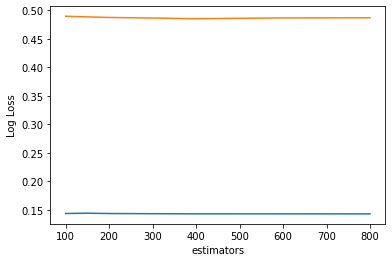

In [ ]:
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators') 
plt.ylabel('Log Loss')

Depth =  5 Train Log Loss  0.4987597089748971 Test Log Loss  0.5229138132904096
Depth =  10 Train Log Loss  0.3551471338299932 Test Log Loss  0.4956579770369946
Depth =  12 Train Log Loss  0.2861725062778491 Test Log Loss  0.49014101504192625
Depth =  15 Train Log Loss  0.21563674820874867 Test Log Loss  0.48928387006686835
Depth =  20 Train Log Loss  0.1594521024254605 Test Log Loss  0.4898835577464145
Depth =  25 Train Log Loss  0.14606495738272524 Test Log Loss  0.49001087236485213
Depth =  50 Train Log Loss  0.1442840062758417 Test Log Loss  0.49068212861159405


Text(0, 0.5, 'Log Loss')

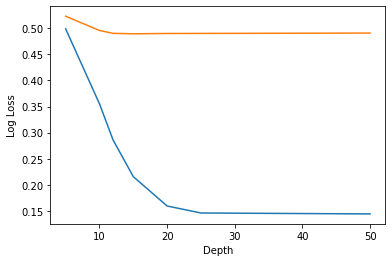

In [ ]:
Depth = [5,10,12,15,20,25,50]
test_scores = []
train_scores = []
for i in Depth:
    clf = RFC(n_estimators=100,max_depth=i,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('Depth = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(Depth,train_scores,label='Train Log Loss')
plt.plot(Depth,test_scores,label='Test Log Loss')
plt.xlabel('Depth') 
plt.ylabel('Log Loss')

estimators =  100 Train Log Loss  0.32447531723862333 Test Log Loss  0.49389869127558206
estimators =  150 Train Log Loss  0.3221514398772211 Test Log Loss  0.49524706325191253
estimators =  200 Train Log Loss  0.3215874489117404 Test Log Loss  0.4917206888794869
estimators =  300 Train Log Loss  0.3230620049677018 Test Log Loss  0.49308478971738273
estimators =  400 Train Log Loss  0.32228213800436484 Test Log Loss  0.49185541577776165
estimators =  600 Train Log Loss  0.32128687513704546 Test Log Loss  0.49126684494995043
estimators =  800 Train Log Loss  0.3214631555391372 Test Log Loss  0.4919561634986168


Text(0, 0.5, 'Log Loss')

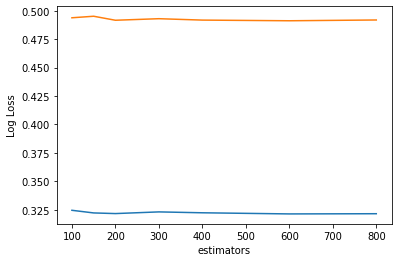

In [ ]:
estimators = [100,150,200,300,400,600,800]
test_scores = []
train_scores = []
for i in estimators:
    clf = RFC(n_estimators=i,max_depth=11,n_jobs=-1)
    clf.fit(X_train,y_train)
    predict_y = clf.predict_proba(X_train)
    log_loss_train = log_loss(y_train, predict_y, eps=1e-15)
    train_scores.append(log_loss_train)
    predict_y = clf.predict_proba(X_test)
    log_loss_test = log_loss(y_test, predict_y, eps=1e-15)
    test_scores.append(log_loss_test)
    print('estimators = ',i,'Train Log Loss ',log_loss_train,'Test Log Loss ',log_loss_test)
plt.plot(estimators,train_scores,label='Train Log Loss')
plt.plot(estimators,test_scores,label='Test Log Loss')
plt.xlabel('estimators') 
plt.ylabel('Log Loss')